In [47]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers
)
import numpy as np
import pandas as pd
import copy



here we perform a scenario discovery. Roadmap

First:  Identify policies that minimize EAD -> set of policies
Second: Optimize set of policies for water level min max (robustness)
Third:  How robust are these policies for other objectives.

First we run the experiments


In [3]:
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time


dike_model, planning_steps = get_model_for_problem_formulation(2)

uncertainties = copy.deepcopy(dike_model.uncertainties)

levers = copy.deepcopy(dike_model.levers)

for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('Expected Annual Damage', variable_name=('A.1_Expected Annual Damage', 'A.2_Expected Annual Damage', 'A.3_Expected Annual Damage', 'A.4_Expected Annual Damage', 'A.5_Expected Annual Damage'), function=<function sum_over at 0x000001D54C698FE0>)
ScalarOutcome('Dike Investment Costs', variable_name=('A.1_Dike Investment Costs', 'A.2_Dike Investment Costs', 'A.3_Dike Investment Costs', 'A.4_Dike Investment Costs', 'A.5_Dike Investment Costs'), function=<function sum_over at 0x000001D54C698FE0>)
ScalarOutcome('RfR Investment Costs', variable_name=('RfR Total Costs',), function=<function sum_over at 0x000001D54C698FE0>)
ScalarOutcome('Evacuation Costs', variable_name=('Expected Evacuation Costs',), function=<function sum_over at 0x000001D54C698FE0>)
ScalarOutcome('Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths', 'A.2_Expected Number of Deaths', 'A.3_Expected Number of Deaths', 'A.4_Expected Number of Deaths', 'A.5_Expected Number of Deaths'), function

Here we run the experiments. We generate quite some scenarios and policies to get a good understanding how the outcomes are influenced by the uncertainty space.

In [4]:
ema_logging.log_to_stderr(ema_logging.INFO)

scenarios = 1000
policies = 10

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios, policies)

experiments, outcomes = results


[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
100%|████████████████████████████████████| 10000/10000 [38:00<00:00,  4.38it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


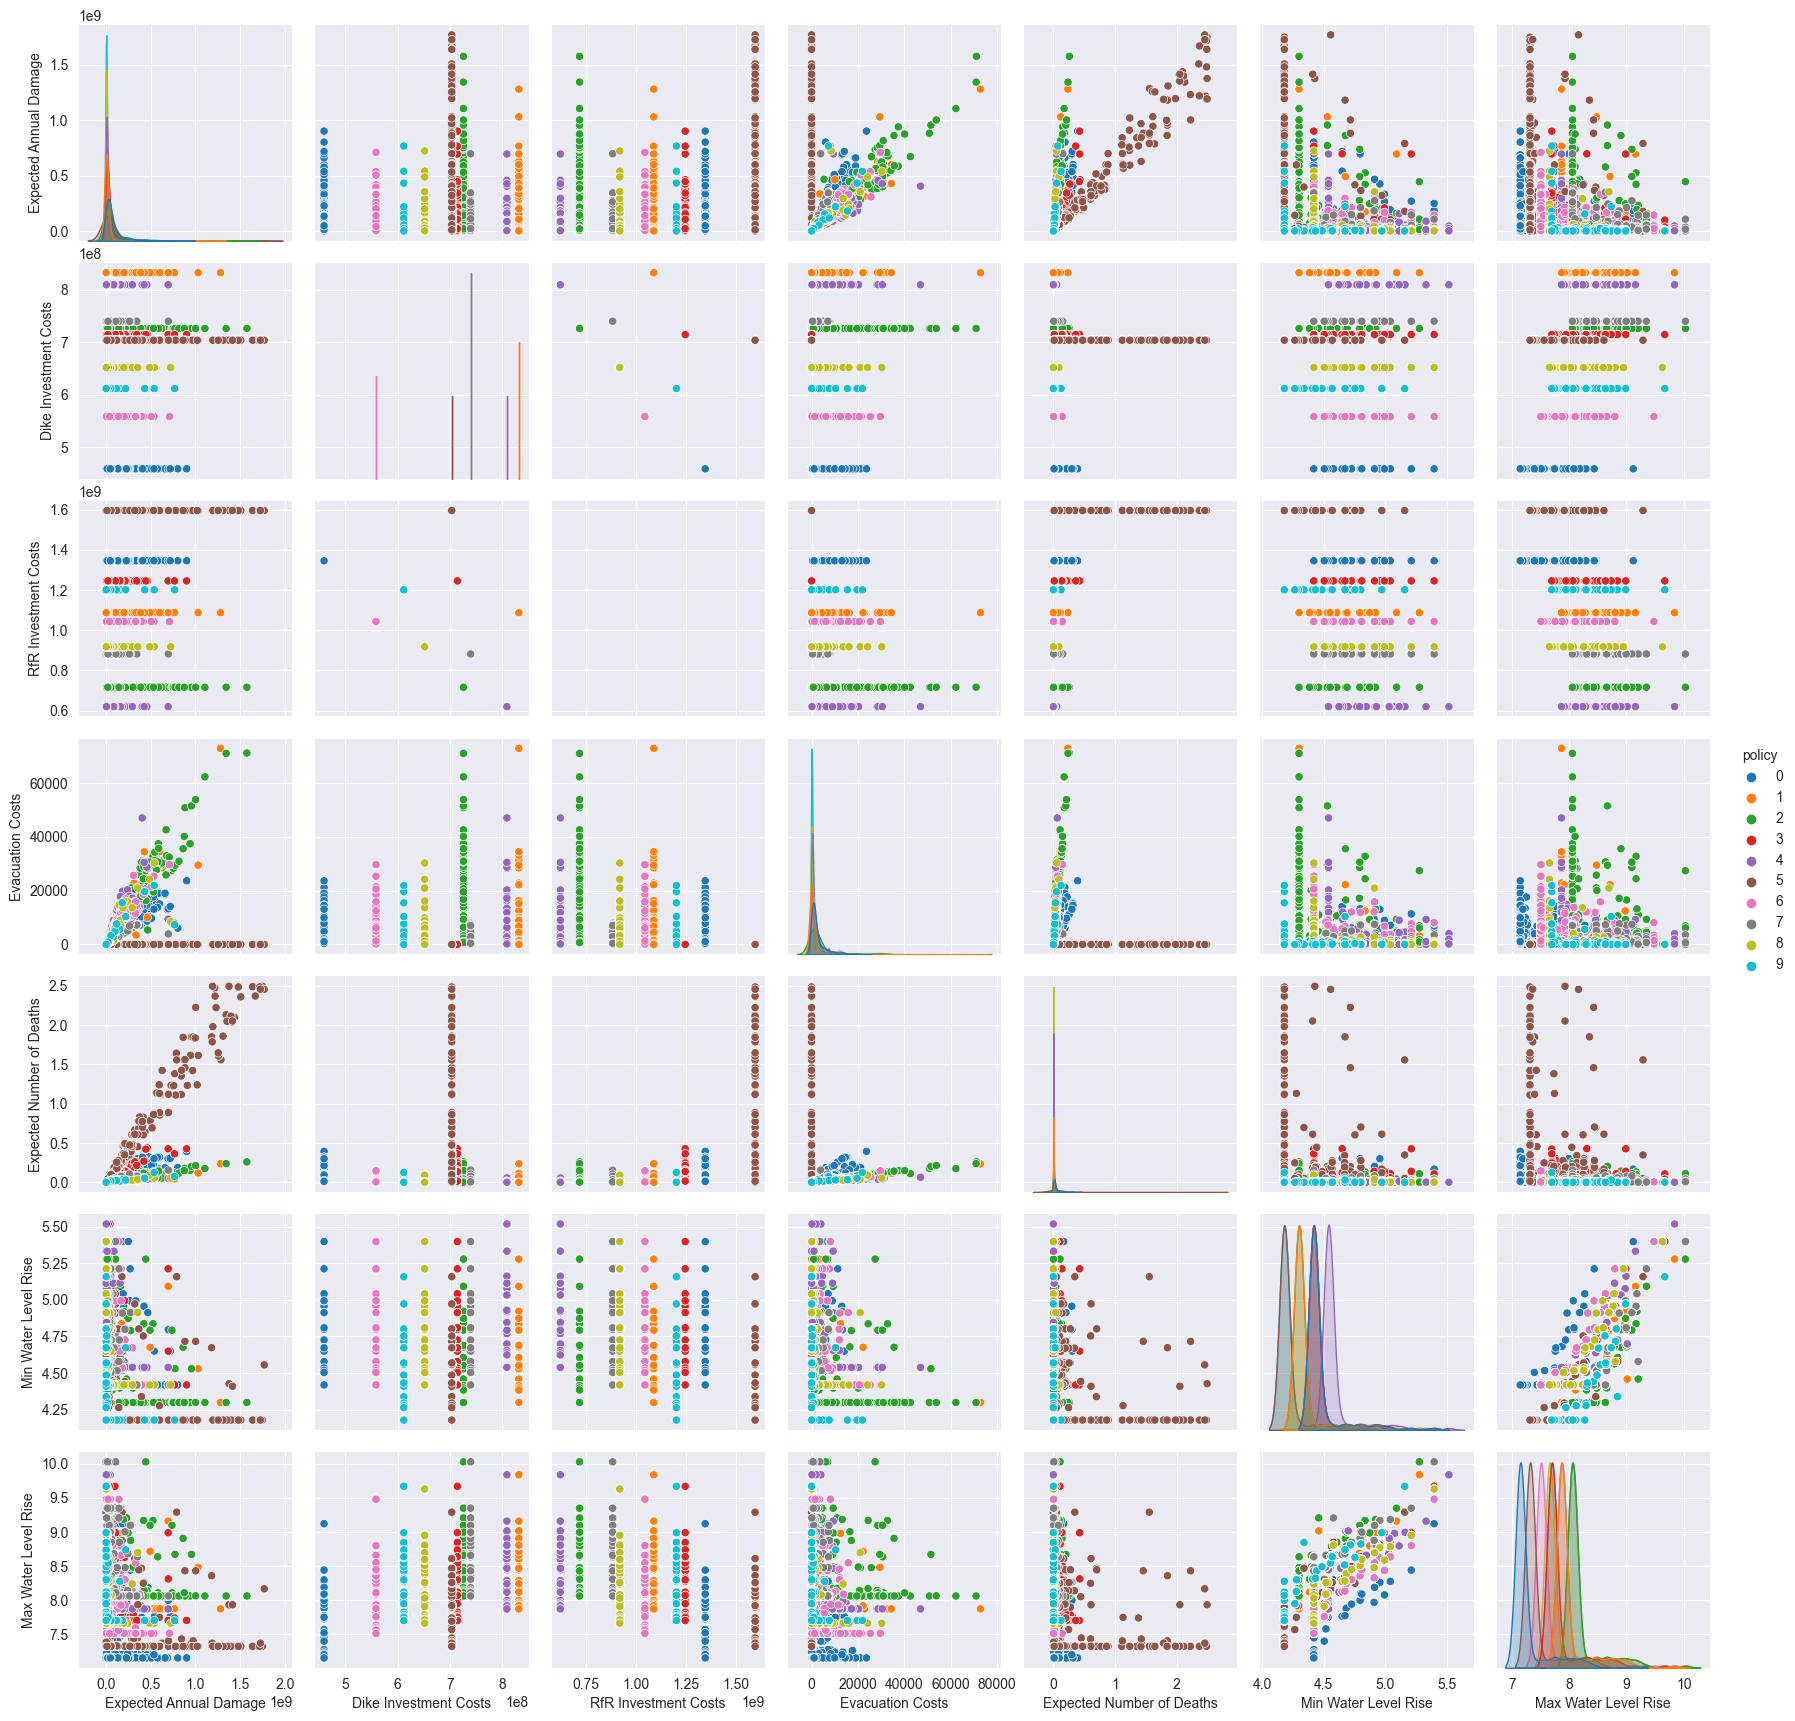

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


policies = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies

sns.pairplot(data, hue='policy',  vars=outcomes.keys(), )
plt.show()

one of the most important things to understand: The uncertainty space for the min water level rise can be quite siginifantly reduced for certain policies.

The uncertainty space for EAD is alsways quite small. There the absolute decrease potential is important.

Very interesting: AN higher min water level rise does not necessarily mean an higher EAD. This means there is a dampening factor involved. (Assumption: Dike increase)

We want to find now the policies that show a better and worse EAD than BAU. -> Subspace partitioning.

For this we have of course to know
: 1\. EAD BAU
: 2\. Water level BAU

We run therefore an experiment to identify EAD BAU and waterlevel BAU


In [7]:
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies_adj = [
    Policy(
        "BAU",
        **dict(
            get_do_nothing_dict()
        )
    )
]

ema_logging.log_to_stderr(ema_logging.INFO)

scenarios = 200

with MultiprocessingEvaluator(dike_model) as evaluator:
    results_bau = evaluator.perform_experiments(scenarios, policies_adj)

experiments_bau, outcomes_bau = results_bau

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 200 scenarios * 1 policies * 1 model(s) = 200 experiments
100%|████████████████████████████████████████| 200/200 [00:45<00:00,  4.38it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [32]:
print(pd.DataFrame(outcomes_bau).describe([.25,.5,.75,.90,.95]))

       Expected Annual Damage  Dike Investment Costs  RfR Investment Costs  \
count            2.000000e+02                  200.0                 200.0   
mean             1.534201e+09                    0.0                   0.0   
std              9.931859e+08                    0.0                   0.0   
min              2.421804e+07                    0.0                   0.0   
25%              5.782409e+08                    0.0                   0.0   
50%              1.544433e+09                    0.0                   0.0   
75%              2.285029e+09                    0.0                   0.0   
90%              2.752636e+09                    0.0                   0.0   
95%              3.184290e+09                    0.0                   0.0   
max              4.507150e+09                    0.0                   0.0   

       Evacuation Costs  Expected Number of Deaths  Min Water Level Rise  \
count             200.0                 200.000000            200

so far so good. EAD mean BAU is 1.5 billion euros and the min water level rise is 4.5 m max water level is 8.35 m

I choose a confidence threshold of 95% ... it is on you to justify that:) How to interpret this:

in 95% of the cases our outcomes will be lower than this value. This means:

This means in 95% the cases we ant a :

: 1\. for EAD we want to have a lower EAD than 3.184290e+09
: 2\. min water level rise exceeding 4.807055
: 3\. optional: the spread between min max can be interpreded as potentially more room of profit for us. Therfore the we want this spread to be higher than 9.155101 -4.807055 =4.348046

but poco e poco. First we devide the subspaces based on the EAD this time of course for our experiments so far. Goal is to identify rules why EADs are higher or lower than EAD objective. We leverage the PRIM stuff from the workbench.



In [85]:

outcomes_df = pd.DataFrame(outcomes)

experiments_df = pd.DataFrame(experiments)

cleaned_experiments = experiments_df.drop(labels=[l.name for l in dike_model.levers], axis=1)#.drop(labels=['policy','model','scenario'],axis=1)







this is quite interesting. All our random policies wer are evaluating are better than BAU or doing nothing. This means it will be very unlikely to get a higher EAD than BAU. How does it look for the water levels?

In [51]:
data = outcomes_df['Min Water Level Rise']

y = data[data<4.807055]

data.describe([.25,.5,.75,.95,.99])



0       4.418700
1       4.418700
2       4.418356
3       4.418700
4       4.418700
          ...   
9995    4.178700
9996    4.178700
9997    4.263910
9998    4.178700
9999    4.178700
Name: Min Water Level Rise, Length: 9505, dtype: float64

With the pure goal of maximizing the water levels this is quite problematic for us. in most of the cases 95.05% of them we have a lower waterlevel than stated in our objectives.

we can increase now the confidence in our BAU scenario to have a more meaingful evaluation. Objective 4.702725

In [84]:
y = np.array(data<4.702725)

10000

slightly better. now we inspect this so to speak worst case space using PRIM.

In [86]:
from ema_workbench.analysis import prim


prim_alg = prim.Prim(cleaned_experiments, y, threshold=0.8)

box1 = prim_alg.find_box()

#print(type(y))

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 10000 points remaining, containing 2226 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.067, coverage: 0.30098831985624436, density: 1.0 restricted_dimensions: 6
